## Calculating the Slope in a PSD in log-log space
19 April 2019

Notebook to show how to calculate the slope of a PSD in log-log space with the following steps:
1. smooth the PSD (boxcar smoothing vs. averaging binned data points--30 data points in each bin)
2. Perform linear fit in log-log space

In [30]:
from analysis import *
from astropy.convolution import convolve, Box1DKernel # for boxcar smoothing 

In [31]:
epic = 220293277 # some faint object in k2 campaign 8
campaign = 8

# load in some sample light curve
lc = lk.search_targetpixelfile(epic, campaign=campaign).download().to_lightcurve(aperture_mask='all')
_, spurious_cadences = lc.flatten().remove_outliers(return_mask=True) # remove spurious cadences


# calculate the PSD
# gotta convert days into sec
freq, power = LS_PSD(lc.time[~spurious_cadences]*86400, lc.flux[~spurious_cadences], f=k2_freq)

Text(0.5, 1.0, 'EPIC 220293277 PSD')

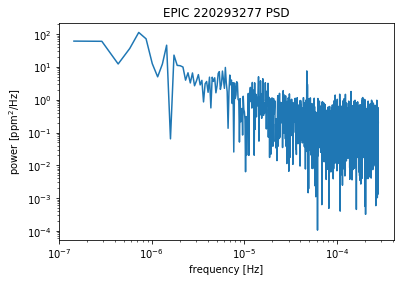

In [32]:
plt.plot(freq, power)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("frequency [Hz]")
plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.title("EPIC %s PSD"%epic)

Now let's try our two methods of smoothing to compare.

In [33]:
# boxcar smoothing
N = 15
p_smooth_boxcar = convolve(power, Box1DKernel(N), boundary='extend')
# (nice and straghtforward)

In [39]:
# binning w/ defined bin-size
N = 30
f_smooth_bin = []
p_smooth_bin = []

i = 0
while i < len(freq):
    if i+N > len(freq):
        f_smooth_bin.append(np.average(freq[i:]))
        p_smooth_bin.append(np.average(power[i:]))
    else:
        f_smooth_bin.append(np.average(freq[i:i+N]))
        p_smooth_bin.append(np.average(power[i:i+N]))
    i += N

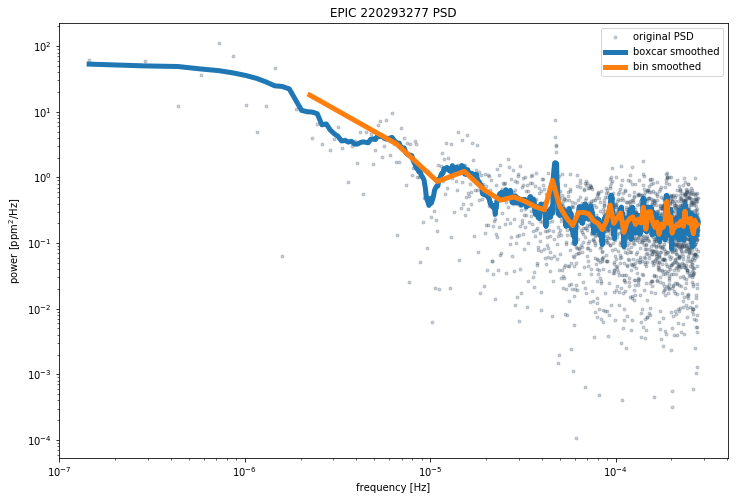

In [40]:
plt.figure(figsize=(12,8))
plt.plot(freq, power, marker='.', ls='', color='#34495e', alpha=0.25, label="original PSD")
plt.plot(freq, p_smooth_boxcar, linewidth=5, alpha=1.0, label="boxcar smoothed")
plt.plot(f_smooth_bin, p_smooth_bin, linewidth=5, alpha=1.0, label="bin smoothed")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("frequency [Hz]")
plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.title("EPIC %s PSD"%epic)
plt.legend()

Fit a line in log-log space.

In [56]:
# transform smoothed data into log-log space 
freq_log = np.log10(freq)
p_log_box = np.log10(p_smooth_boxcar)

f_log_bin = np.log10(f_smooth_bin)
p_log_bin = np.log10(p_smooth_bin)

# perform the fit
fit_box = np.polyfit(freq_log, p_log_box, 1)
fit_bin = np.polyfit(f_log_bin, p_log_bin, 1)

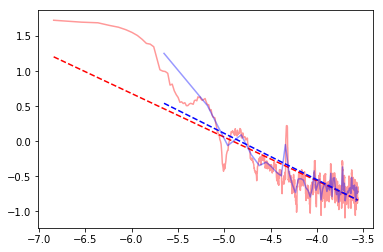

In [57]:
# preliminary plot
plt.plot(freq_log, p_log_box, 'r-', alpha=0.4)
plt.plot(freq_log, freq_log*fit_box[0]+fit_box[1], 'r--')

plt.plot(f_log_bin, p_log_bin, 'b-', alpha=0.4)
plt.plot(f_log_bin, f_log_bin*fit_bin[0]+fit_bin[1], 'b--')

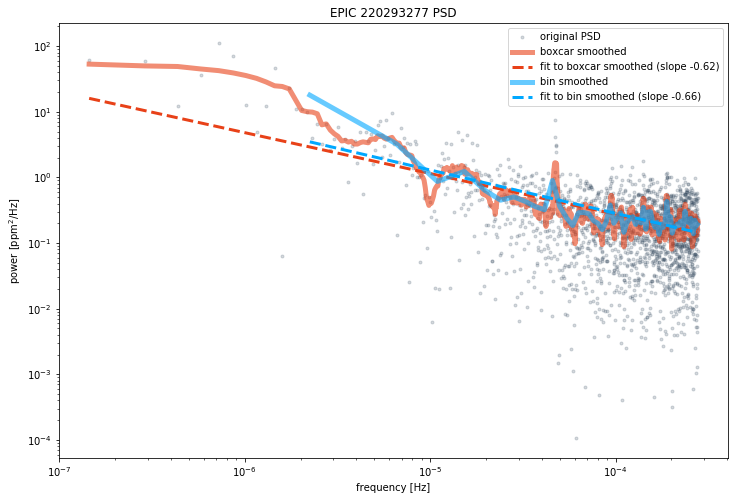

In [58]:
# convert it back from log-log space to plot consistently
p_fit_box = 10**(freq_log*fit_box[0]+fit_box[1])
p_fit_bin = 10**(f_log_bin*fit_bin[0]+fit_bin[1])


plt.figure(figsize=(12,8))
plt.plot(freq, power, marker='.', ls='', color='#34495e', alpha=0.2, label="original PSD")

plt.plot(freq, p_smooth_boxcar, color='#e84118', linewidth=5, alpha=0.6, label="boxcar smoothed")
plt.plot(freq, p_fit_box, color='#e84118', ls='--', linewidth=3, label="fit to boxcar smoothed (slope %.2f)"%fit_box[0])

plt.plot(f_smooth_bin, p_smooth_bin, color='#00a8ff', linewidth=5, alpha=0.6, label="bin smoothed")
plt.plot(f_smooth_bin, p_fit_bin,  color='#00a8ff', ls='--', linewidth=3, label="fit to bin smoothed (slope %.2f)"%fit_bin[0])

plt.xscale('log')
plt.yscale('log')
plt.xlabel("frequency [Hz]")
plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.title("EPIC %s PSD"%epic)
plt.legend()

Looks good.

---
Below, I draft putting it into function form that will be added to ```analysis.py``` when complete.